In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('..')
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling
import selex_dca, utils

/home/scrotti/Aptamer2025py/experiments/../sampling.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
round_ids = ['Input_R1_N', 'OplusR1_N', 'OplusR2_N']

dtype = torch.float32

In [3]:
sequences, log_multinomial_factors = utils.sequences_from_files_ab6(round_ids, return_log_multinomial_factors=True)

In [5]:
sequences_oh = [utils.one_hot(seq, num_classes=21) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [ ]:
fi_tuple, fij_tuple, _ = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)
fij = torch.stack(fij_tuple)
_, L, q = fi.size()

In [ ]:
# device = torch.device('cpu')
device = utils.best_device()

In [ ]:
tr = tree.Tree()
tr.add_node(-1, name = 'OplusR1_N')
tr.add_node(0, name = 'OplusR2_N')

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [ ]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [ ]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype).to(device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype).to(device)

In [ ]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.ParamsCallback(save_every=100)]

In [ ]:
lr = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)

In [ ]:
n_sweeps = 10
lr = 0.1
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               log_multinomial_factors=log_multinomial_factors,
               callbacks=callbacks, log_weights=log_weights, optimizer=optimizer)

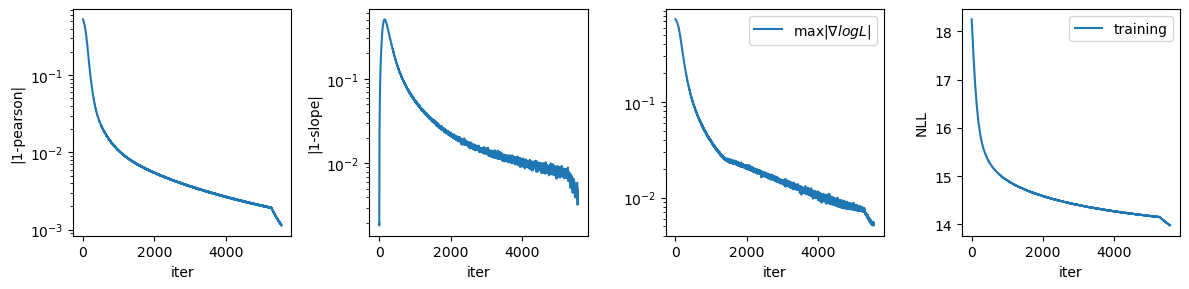

In [90]:
callbacks[0].plot();

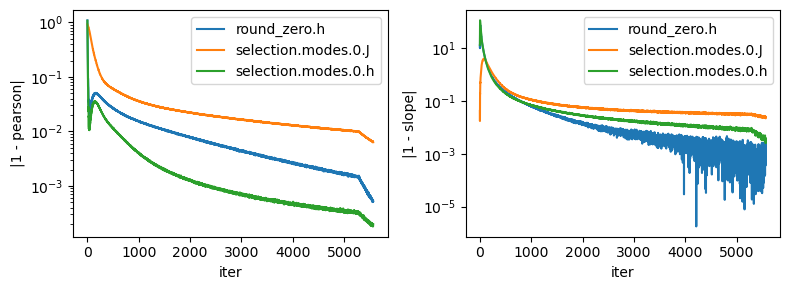

In [91]:
callbacks[0].plot_pearson_detail(figsize=(8,3));

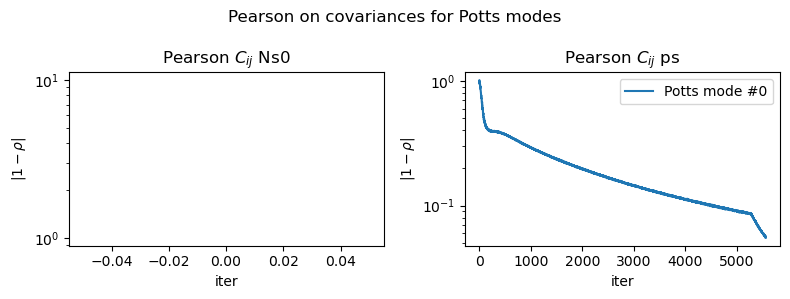

In [92]:
fig, ax = callbacks[1].plot(figsize=(8,3))

In [ ]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

In [ ]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
plt.title('Contact map');
# display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [ ]:
(h ** 2).sum(1)

In [ ]:
import logomaker
import pandas as pd

logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_PROTEIN)))

## Compare against counts

In [68]:
sequences_unique_all, counts_unique, enrichments = utils.group_rounds(sequences_oh, return_enrichments=True)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Calculating enrichments...
Finished


In [71]:
logNst_unique = [- model.compute_energy_up_to_round(sequences_unique_all, t).detach()
                for t in range(n_rounds)]

Text(0.5, 1.0, 'logNst vs log count')

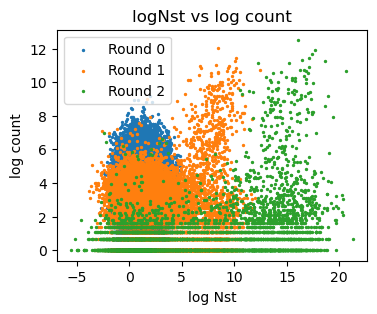

In [75]:
n_subsample = 10**5
n_seq = len(sequences_unique_all)
idx = random.sample(range(n_seq), min(n_subsample, n_seq))
fig1, ax = plt.subplots(figsize=(4,3))
for t in range(n_rounds):
    ax.scatter(logNst_unique[t][idx], torch.log(counts_unique[t][idx]), 
               label=f'Round {t}', s=2)
    ax.set_xlabel('log Nst')
    ax.set_ylabel('log count')
    ax.legend()
ax.set_title('logNst vs log count')

In [83]:
logps_unique = - model.selection_energy_at_round(sequences_unique_all, 1).detach()

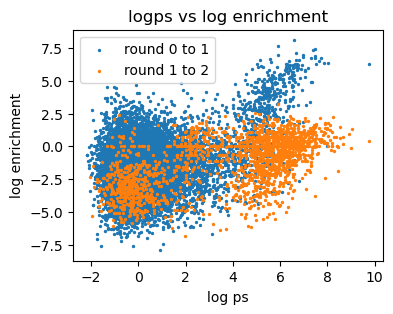

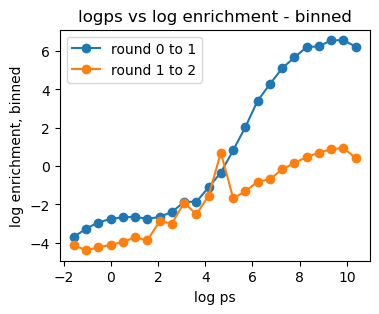

In [88]:
utils.binned_logenrichments(model, sequences_unique_all, enrichments, counts_unique, 
                            plot=True, n_subsample=n_subsample);

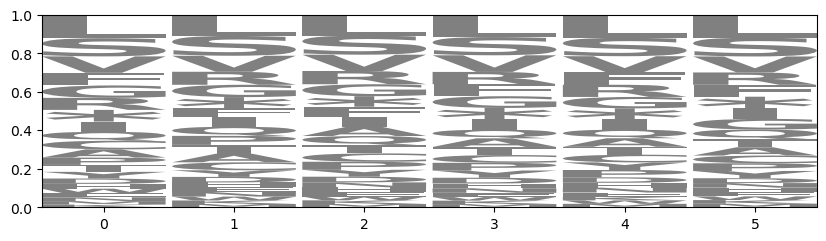

In [78]:
logomaker.Logo(pd.DataFrame(fi[0], columns=list(utils.TOKENS_PROTEIN)));

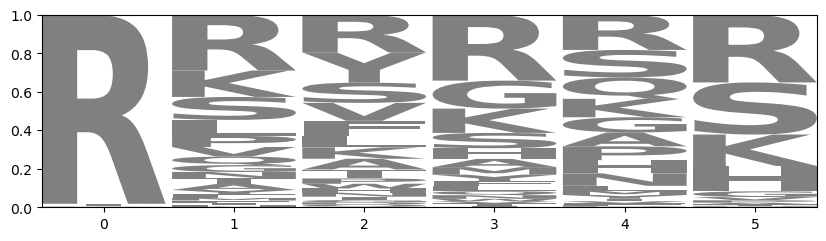

In [82]:
logomaker.Logo(pd.DataFrame(fi[-1], columns=list(utils.TOKENS_PROTEIN)));

In [80]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

Selection field


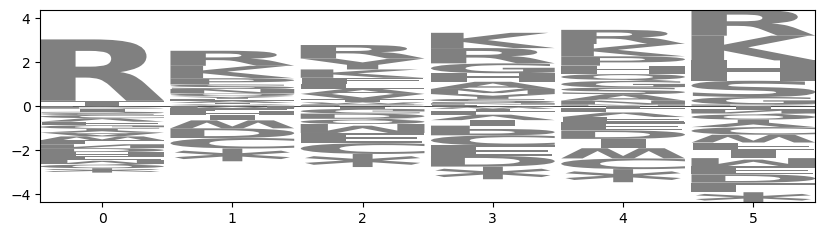

In [81]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_PROTEIN)))
print('Selection field');